## 권철민 강사의 강의를 수강하고 복습하는 차원에서 만든 파일입니다
* 이번엔 mmdetection을 통한 inference 과정에 익숙해지는 것에 목적을 갖고 pretrain된 모델을 사용

### mmdetection 설치
* pytorch version은 1.13으로 진행
* mmdetection version 또한 2.x 버전으로 진행

In [ ]:
import torch
print(torch.__version__)

In [ ]:
!pip install torch==1.13.0+cu116 torchvision==0.14.0+cu116 --extra-index-url https://download.pytorch.org/whl/cu116

In [ ]:
# mmcv를 사용하기 위해선 mmcv-full을 설치해야 한다
# https://velog.io/@boom109/mmdetection-%EC%84%A4%EC%B9%98-install-mmdetection 참고
!pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu116/torch1.13/index.html

In [ ]:
# mmdetetction 2.x branch의 소스코드 기반으로 mmdetection 설치 필요
!git clone --branch 2.x https://github.com/open-mmlab/mmdetection.git
# mmdetection은 git에서 clone해서 pip로 관리되지 않는 파일이라 수동 설치 필요
!cd mmdetection; python setup.py install

In [1]:
# 이번 kernel 실행 전에 kernel restart 필요
from mmdet.apis import init_detector, inference_detector
import mmcv

/opt/conda/lib/python3.10/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(


### MS-COCO 데이터를 기반으로 faster rcnn pretrained 모델을 활용해 inference 수행

* faster rcnn pretrained 모델을 다운
* faster rcnn용 config 파일을 설정
* inference용 모델을 생성하고 inference 적용해 과정 이해

In [2]:
# pretrained된 weight 모델을 다운로드 받기 위해 mmdetection/checkpoints dir를 만든다
!cd mmdetection; mkdir checkpoints

In [6]:
! pwd

/kaggle/working


In [11]:
# checkpoints dir 안에는 pretrained model 정보가 들어있음
!wget -O /kaggle/working/mmdetection/checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth http://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_fpn_1x_coco/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth

--2024-04-27 04:55:28--  http://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_fpn_1x_coco/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 8.25.82.242, 8.25.82.243, 8.25.82.241, ...
Connecting to download.openmmlab.com (download.openmmlab.com)|8.25.82.242|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 167287506 (160M) [application/octet-stream]
Saving to: '/kaggle/working/mmdetection/checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth'

/kaggle/working/mmd 100%[===================>] 159.54M  6.98MB/s    in 24s     

2024-04-27 04:55:53 (6.62 MB/s) - '/kaggle/working/mmdetection/checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth' saved [167287506/167287506]



In [12]:
# 다운로드 여부 확인
!ls -lia /kaggle/working/mmdetection/checkpoints

total 163376
788642 drwxr-xr-x  2 root root      4096 Apr 27 04:51 .
786440 drwxr-xr-x 19 root root      4096 Apr 27 04:50 ..
788643 -rw-r--r--  1 root root 167287506 Nov  2  2021 faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth


In [15]:
# config 파일을 설정하고, 다운로드 받은 pretrained 모델을 checkpoint로 설정. 
config_file = '/kaggle/working/mmdetection/configs/faster_rcnn/faster_rcnn_r50_fpn_1x_coco.py'
checkpoint_file = '/kaggle/working/mmdetection/checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth'

In [16]:
# config 파일과 pretrained 모델을 기반으로 detector 모델을 생성
# init_detector가 pretrained된 모델을 갖고 온다
from mmdet.apis import init_detector, inference_detector

'''
init_detector() 인자로 config와 checkpoint 입력
config 안에는 여러가지 알고리즘에 따라 적용할 수 있는 모델의 config들이 있음
faster_rcnn_r50이면 resnet 기반 cnn 층이 50개가 있다는 뜻이다
faster_rcnn(모델)_r50(cnn층의 수)_fcn(neck)_1x(학습 epoch 수, 1x는 12, 2x 24 등등)_coco(학습 데이터 세트)
참고로 일부 모델 config 파일 들어가서 보면 base 경로가 있는데 이는 겹치는 부분을 따로 base로 빼둔 것임
'''
model = init_detector(config_file, checkpoint_file, device='cuda:0')

load checkpoint from local path: /kaggle/working/mmdetection/checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth


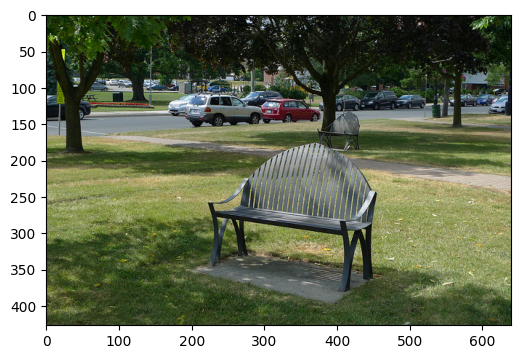

In [18]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
img = '/kaggle/working/mmdetection/demo/demo.jpg'

img_arr = cv2.cvtColor((cv2.imread(img)), cv2.COLOR_BGR2RGB)
plt.figure(figsize=(6,6))
plt.imshow(img_arr)

In [19]:
img = '/kaggle/working/mmdetection/demo/demo.jpg'

# inference_detector의 인자로 string(file경로) 혹은 ndarray가 단일 또는 list 형태로 입력 가능
results = inference_detector(model, img)

/opt/conda/lib/python3.10/site-packages/mmdet-2.28.2-py3.10.egg/mmdet/datasets/utils.py:66: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  warnings.warn(


In [20]:
# result 길이가 80개인 이유는 coco dataset이 80개니까
print(type(results), len(results))

# results는 겉에는 list로, 안에는 ndarray로 구성되어 있다
print(type(results[0]))

<class 'list'> 80
<class 'numpy.ndarray'>


In [21]:
results[0]

array([[3.75348572e+02, 1.19171005e+02, 3.81950867e+02, 1.34460617e+02,
        1.35454744e-01],
       [5.32362000e+02, 1.09554726e+02, 5.40526550e+02, 1.25222633e+02,
        8.88786465e-02],
       [3.61124298e+02, 1.09049202e+02, 3.68625610e+02, 1.22483063e+02,
        7.20717609e-02]], dtype=float32)

In [22]:
'''
results는 타입은 list형으로 coco class의 0부터 79까지 class_id 별로 80개의 array를 가짐
개별 array들은 각 클래스별로 5개의 값(좌표값과 class 별로 cofidence)를 가진다
좌표는 좌상단 우하단을 기준으로 한다
개별 array의 shape는 detect된 (obj들의 수, 4개의 좌표, confidence 값)으로 구성되어 있고 전체 list로 보면 이게 80개
참고로 results[1]을 보면 암것도 없는데 이건 [1]번 class_id로는 detect된 것이 없다는 뜻이다
'''

results

[array([[3.75348572e+02, 1.19171005e+02, 3.81950867e+02, 1.34460617e+02,
         1.35454744e-01],
        [5.32362000e+02, 1.09554726e+02, 5.40526550e+02, 1.25222633e+02,
         8.88786465e-02],
        [3.61124298e+02, 1.09049202e+02, 3.68625610e+02, 1.22483063e+02,
         7.20717609e-02]], dtype=float32),
 array([], shape=(0, 5), dtype=float32),
 array([[6.09650024e+02, 1.13805901e+02, 6.34511658e+02, 1.36951904e+02,
         9.88766015e-01],
        [4.81773712e+02, 1.10480995e+02, 5.22459717e+02, 1.30407104e+02,
         9.87157285e-01],
        [1.01821303e+00, 1.12144722e+02, 6.04374390e+01, 1.44173752e+02,
         9.83206093e-01],
        [2.94623749e+02, 1.17035233e+02, 3.78022675e+02, 1.50550873e+02,
         9.71326888e-01],
        [3.96328979e+02, 1.11203323e+02, 4.32490540e+02, 1.32729263e+02,
         9.67802167e-01],
        [5.90976318e+02, 1.10802658e+02, 6.15401917e+02, 1.26493553e+02,
         9.59415138e-01],
        [2.67582001e+02, 1.05686005e+02, 3.28818756

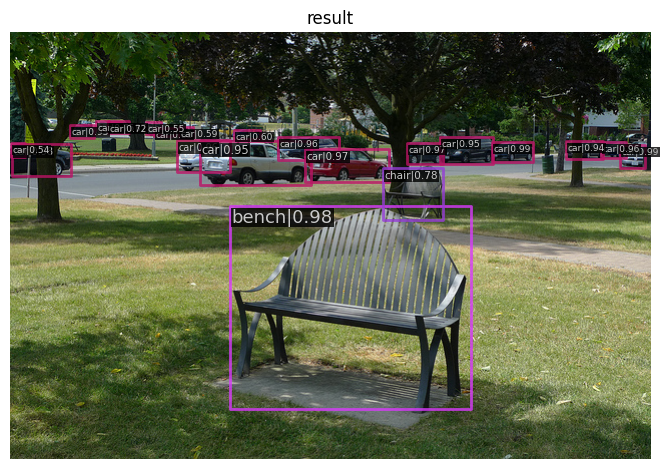

In [23]:
from mmdet.apis import show_result_pyplot

# inference된 결과를 원본 이미지에 적용하여 img 생성
# defualt score threshold는 0.3이며 필요에 따라 조정 가능
show_result_pyplot(model, img, results, score_thr=0.5)

### Model의 config 설정 확인하기

In [24]:
# python __dict__는 class object의 속성 정보를 확인하는데 dict 형태로 꺼내줘서 편하다
model.__dict__

{'training': False,
 '_parameters': OrderedDict(),
 '_buffers': OrderedDict(),
 '_non_persistent_buffers_set': set(),
 '_backward_hooks': OrderedDict(),
 '_is_full_backward_hook': None,
 '_forward_hooks': OrderedDict(),
 '_forward_pre_hooks': OrderedDict(),
 '_state_dict_hooks': OrderedDict(),
 '_load_state_dict_pre_hooks': OrderedDict(),
 '_load_state_dict_post_hooks': OrderedDict(),
 '_modules': OrderedDict([('backbone',
               ResNet(
                 (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
                 (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                 (relu): ReLU(inplace=True)
                 (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
                 (layer1): ResLayer(
                   (0): Bottleneck(
                     (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
                     (bn1): Bat

In [25]:
print(model.cfg.pretty_text)

model = dict(
    type='FasterRCNN',
    backbone=dict(
        type='ResNet',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        frozen_stages=1,
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=True,
        style='pytorch',
        init_cfg=None),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        num_outs=5),
    rpn_head=dict(
        type='RPNHead',
        in_channels=256,
        feat_channels=256,
        anchor_generator=dict(
            type='AnchorGenerator',
            scales=[8],
            ratios=[0.5, 1.0, 2.0],
            strides=[4, 8, 16, 32, 64]),
        bbox_coder=dict(
            type='DeltaXYWHBBoxCoder',
            target_means=[0.0, 0.0, 0.0, 0.0],
            target_stds=[1.0, 1.0, 1.0, 1.0]),
        loss_cls=dict(
            type='CrossEntropyLoss', use_sigmoid=True, loss_weight=1.0),
        loss_bbox=dict(type='L1Loss', loss_weight=1.

### array를 inferecne_detector()에 입력
* array를 통째로 inference_detector()에 입력하는 경우는 원본 array를 RGB로 바꾸지 않고 BGR 형태로 입력해야 한다
* 참고로 이전까지는 file img를 str을 통한 절대경로로 따와서 model에 넣었다

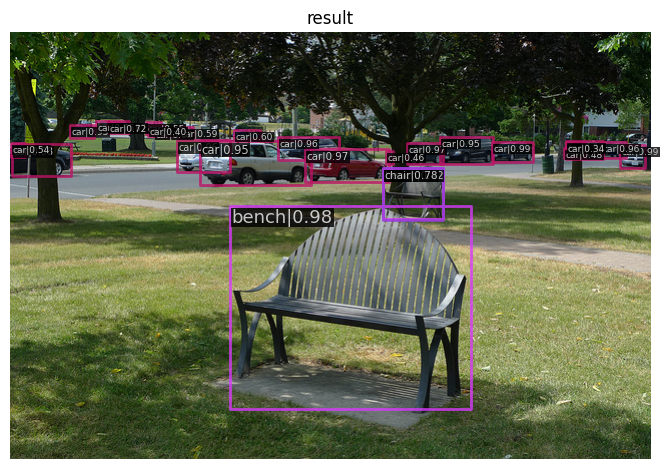

In [26]:
import cv2

# RGB가 아닌 BGR로 입력
img_arr = cv2.imread('/kaggle/working/mmdetection/demo/demo.jpg')
results = inference_detector(model, img_arr)

show_result_pyplot(model, img_arr, results)

### show_result_pyplot()을 사용하지 않고 inference 결과를 image로 표현
* model과 image array를 입력하면 해당 img를 처리하는 get_detected_img() 함수 만들기
* COCO class mapping은 0부터 순차진행
* results에 들어있는 array는 값이 없는 경우 해당 class id 값으로 obj가 detect 되지 않는다
* 개별 class의 score threshold에 제한을 둔다

In [27]:
# 0부터 순차적으로 클래스 매핑된 label 적용.
labels_to_names_seq = {0:'person',1:'bicycle',2:'car',3:'motorbike',4:'aeroplane',5:'bus',6:'train',7:'truck',8:'boat',9:'traffic light',10:'fire hydrant',
                        11:'stop sign',12:'parking meter',13:'bench',14:'bird',15:'cat',16:'dog',17:'horse',18:'sheep',19:'cow',20:'elephant',
                        21:'bear',22:'zebra',23:'giraffe',24:'backpack',25:'umbrella',26:'handbag',27:'tie',28:'suitcase',29:'frisbee',30:'skis',
                        31:'snowboard',32:'sports ball',33:'kite',34:'baseball bat',35:'baseball glove',36:'skateboard',37:'surfboard',38:'tennis racket',39:'bottle',40:'wine glass',
                        41:'cup',42:'fork',43:'knife',44:'spoon',45:'bowl',46:'banana',47:'apple',48:'sandwich',49:'orange',50:'broccoli',
                        51:'carrot',52:'hot dog',53:'pizza',54:'donut',55:'cake',56:'chair',57:'sofa',58:'pottedplant',59:'bed',60:'diningtable',
                        61:'toilet',62:'tvmonitor',63:'laptop',64:'mouse',65:'remote',66:'keyboard',67:'cell phone',68:'microwave',69:'oven',70:'toaster',
                        71:'sink',72:'refrigerator',73:'book',74:'clock',75:'vase',76:'scissors',77:'teddy bear',78:'hair drier',79:'toothbrush' }

labels_to_names = {1:'person',2:'bicycle',3:'car',4:'motorcycle',5:'airplane',6:'bus',7:'train',8:'truck',9:'boat',10:'traffic light',
                    11:'fire hydrant',12:'street sign',13:'stop sign',14:'parking meter',15:'bench',16:'bird',17:'cat',18:'dog',19:'horse',20:'sheep',
                    21:'cow',22:'elephant',23:'bear',24:'zebra',25:'giraffe',26:'hat',27:'backpack',28:'umbrella',29:'shoe',30:'eye glasses',
                    31:'handbag',32:'tie',33:'suitcase',34:'frisbee',35:'skis',36:'snowboard',37:'sports ball',38:'kite',39:'baseball bat',40:'baseball glove',
                    41:'skateboard',42:'surfboard',43:'tennis racket',44:'bottle',45:'plate',46:'wine glass',47:'cup',48:'fork',49:'knife',50:'spoon',
                    51:'bowl',52:'banana',53:'apple',54:'sandwich',55:'orange',56:'broccoli',57:'carrot',58:'hot dog',59:'pizza',60:'donut',
                    61:'cake',62:'chair',63:'couch',64:'potted plant',65:'bed',66:'mirror',67:'dining table',68:'window',69:'desk',70:'toilet',
                    71:'door',72:'tv',73:'laptop',74:'mouse',75:'remote',76:'keyboard',77:'cell phone',78:'microwave',79:'oven',80:'toaster',
                    81:'sink',82:'refrigerator',83:'blender',84:'book',85:'clock',86:'vase',87:'scissors',88:'teddy bear',89:'hair drier',90:'toothbrush',
                    91:'hair brush'}

In [48]:
# model과 원본 이미지 array, filtering할 기준 class confidence score를 인자로 갖는 inference 시각화용 함수 생성
def get_detected_img(model, img_array, score_threshold=0.3, is_print=True):
    # 인자로 들어온 img arr 복사
    draw_img = img_array.copy()
    bbox_color = (0, 255, 0)
    text_color = (0, 0, 255)
    
    # model과 image array를 입력  인자로 inference detection 수행하고 결과를 results로
    # results는 80개의 2치원 array를 갖는 list
    # array[0], array[1] 단위로 출력
    results = inference_detector(model, img_array)
    
    # 80개의 arary 원소를 갖는 results 리스트를 loop 돌면서 개별 2차원 array들을 추출히고 이를 기반으로 이미지 시각화
    # results 리스트의 위치 index가 바로 coco 매핑된 class_id, 여기서 result_ind가 class_id
    # 개별 2차원 array에 오브젝트별로 좌표와 cofidence score 값을 가짐
    for result_ind, result in enumerate(results):
        # 개별 2차원 array의 rwo size == 0이면 해당 class_id로는 값이 없어 바로 다음 loop 진행
        if len(result) == 0:
            continue
        
        # 2차원 array에서 score threshold에 해당하는 값이 함수 인자로 받은 threshold 값보다 작으면 img에 표시X
        result_filtered = result[np.where(result[:,4] > score_threshold)]
        
        # 해당 클래스 별로 detect된 여러 여러개의 obj 정보가 2차원 array에 담겼고 이 2차원 array를 row수만큼 iterate
        for i in range(len(result_filtered)):
            # 좌상단 우하단 좌표 추출
            # 또한 픽셀 좌표로 써야해서 int로 변환
            left = int(result_filtered[i,0])
            top = int(result_filtered[i,1])
            right = int(result_filtered[i,2])
            bottom = int(result_filtered[i,3])
            caption = "{}: {:.4f}".format(labels_to_names_seq[result_ind], result_filtered[i,4])
            cv2.rectangle(draw_img, (left, top), (right, bottom), color=bbox_color, thickness=2)
            cv2.putText(draw_img,caption, (left, top -5),cv2.FONT_HERSHEY_SIMPLEX, 0.37, text_color, 1)
            if is_print:
                print(caption)
                
    return draw_img

car: 0.9888
car: 0.9872
car: 0.9832
car: 0.9713
car: 0.9678
car: 0.9594
car: 0.9593
car: 0.9568
car: 0.9510
car: 0.9459
car: 0.9440
car: 0.9331
car: 0.8663
car: 0.8268
car: 0.7535
car: 0.7166
car: 0.6008
car: 0.5920
car: 0.5540
car: 0.5435
bench: 0.9778
chair: 0.7779


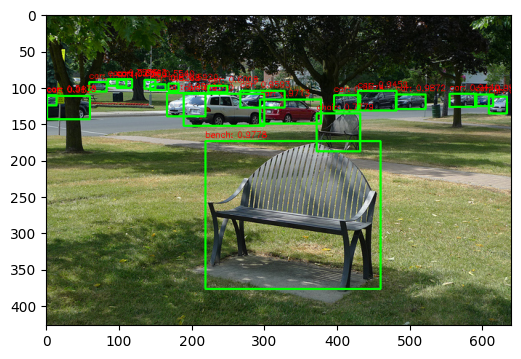

In [51]:
import matplotlib.pyplot as plt

img_arr = cv2.imread('/kaggle/working/mmdetection/demo/demo.jpg')
detected_img = get_detected_img(model, img_arr, score_threshold=0.5, is_print=True)
detected_img = cv2.cvtColor(detected_img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(6,6))
plt.imshow(detected_img)

In [52]:
!pwd

/kaggle/working


In [53]:
!mkdir data

In [54]:
!wget -O /kaggle/working/data/beatles01.jpg https://raw.githubusercontent.com/chulminkw/DLCV/master/data/image/beatles01.jpg
!ls -lia /kaggle/working/data/beatles01.jpg

--2024-04-27 05:54:06--  https://raw.githubusercontent.com/chulminkw/DLCV/master/data/image/beatles01.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 383118 (374K) [image/jpeg]
Saving to: '/kaggle/working/data/beatles01.jpg'

/kaggle/working/dat 100%[===================>] 374.14K  --.-KB/s    in 0.03s   

2024-04-27 05:54:06 (14.5 MB/s) - '/kaggle/working/data/beatles01.jpg' saved [383118/383118]

788646 -rw-r--r-- 1 root root 383118 Apr 27 05:54 /kaggle/working/data/beatles01.jpg


person: 0.9988
person: 0.9982
person: 0.9980
person: 0.9971
person: 0.9604
car: 0.9693
car: 0.9686
car: 0.9648
car: 0.9517
car: 0.9254
car: 0.9030
car: 0.8312
car: 0.8008
car: 0.7331
car: 0.6208
tie: 0.5924


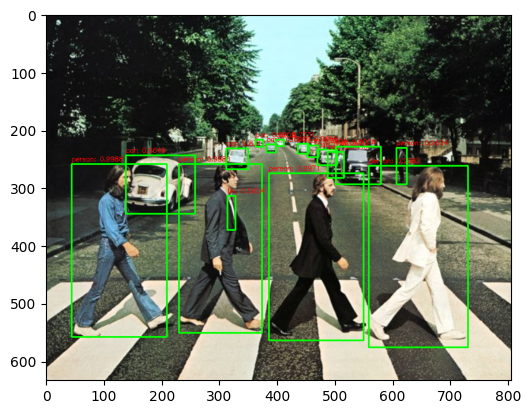

In [55]:
img_arr2 = cv2.imread('/kaggle/working/data/beatles01.jpg')
detected_img = get_detected_img(model, img_arr2, score_threshold=0.5, is_print=True)
detected_img = cv2.cvtColor(detected_img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(6,6))
plt.imshow(detected_img)

### Video Inference 수행
* mmdetection의 video_demo.py대로 video inference 수행 시 image 처리 시간이 오래 걸린다
* 이미지 처리 로직을 변경해 속도를 끌어올린다

In [70]:
!wget -O /kaggle/working/data/John_Wick_small.mp4 https://github.com/chulminkw/DLCV/blob/master/data/video/John_Wick_small.mp4?raw=true

--2024-04-27 06:25:36--  https://github.com/chulminkw/DLCV/blob/master/data/video/John_Wick_small.mp4?raw=true
Resolving github.com (github.com)... 140.82.116.3
Connecting to github.com (github.com)|140.82.116.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/chulminkw/DLCV/raw/master/data/video/John_Wick_small.mp4 [following]
--2024-04-27 06:25:36--  https://github.com/chulminkw/DLCV/raw/master/data/video/John_Wick_small.mp4
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/chulminkw/DLCV/master/data/video/John_Wick_small.mp4 [following]
--2024-04-27 06:25:36--  https://raw.githubusercontent.com/chulminkw/DLCV/master/data/video/John_Wick_small.mp4
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.

In [72]:
# video detection 수행

import cv2

# opencv의 videoCapture 안 쓰고 mmcv의 videoReader로 대체
video_reader = mmcv.VideoReader('/kaggle/working/data/John_Wick_small.mp4')
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
video_writer = cv2.VideoWriter('/kaggle/working/data/John_Wick_small_out1.mp4', fourcc, video_reader.fps, (video_reader.width, video_reader.height))

# mmcv.track_iter_progress(video_reader)는 모델과 frame 인자를 주면 result를 반환한다
for frame in mmcv.track_iter_progress(video_reader):
    result = inference_detector(model, frame)
    frame = model.show_result(frame, result,score_thr=0.5)  # 이 부분 성능이 안 좋아 전체적인 시간이 밀린다
    
    video_writer.write(frame)
    
if video_writer:
    video_writer.release()

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 58/58, 4.9 task/s, elapsed: 12s, ETA:     0s


In [68]:
! ls -lia /kaggle/working/data

total 388
788645 drwxr-xr-x 2 root root   4096 Apr 27 06:04 .
786438 drwxr-xr-x 6 root root   4096 Apr 27 05:53 ..
788647 -rw-r--r-- 1 root root    258 Apr 27 06:17 John_Wick_small.mp4
788646 -rw-r--r-- 1 root root 383118 Apr 27 05:54 beatles01.jpg


In [76]:
import time

def do_detected_video(model, input_path, output_path, score_threshold, do_print=True):
    
    cap = cv2.VideoCapture(input_path)
    codec = cv2.VideoWriter_fourcc(*'XVID')
    
    vid_size  = (round(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), round(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)))
    vid_fps = cap.get(cv2.CAP_PROP_FPS)
    
    vid_writer = cv2.VideoWriter(output_path, codec, vid_fps, vid_size)
    
    frame_cnt = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    print(frame_cnt)
    btime = time.time()
    while True:
        hasFrame, img_frame = cap.read()
        if not hasFrame:
            print("더이상 처리할 frame 없음")
            break
        stime = time.time()
        img_frame = get_detected_img(model, img_frame, score_threshold=0.5, is_print=True)
        if do_print:
            print('frame detection 수행시간:', round(time.time() - btime, 4))
        vid_writer.write(img_frame)
        
    # 루프 끝난 후
    vid_writer.release()
    cap.release()
    
    print('최종 detection 완료 수행 시간:', round(time.time() - btime, 4))

In [77]:
do_detected_video(model, '/kaggle/working/data/John_Wick_small.mp4', '/kaggle/working/data/John_Wick_small_out2.mp4', score_threshold=0.5, do_print=True)

OpenCV: FFMPEG: tag 0x44495658/'XVID' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


58
person: 0.9925
person: 0.8018
bicycle: 0.5235
car: 0.9746
car: 0.9675
car: 0.9377
car: 0.9145
car: 0.8243
motorbike: 0.7699
frame detection 수행시간: 0.0888
person: 0.9933
person: 0.7676
bicycle: 0.5100
car: 0.9749
car: 0.9670
car: 0.9382
car: 0.9195
car: 0.8495
motorbike: 0.8613
frame detection 수행시간: 0.171
person: 0.6206
person: 0.5919
person: 0.5551
car: 0.9788
car: 0.9777
car: 0.9755
car: 0.8107
bus: 0.8772
frame detection 수행시간: 0.2535
person: 0.8545
person: 0.7540
person: 0.5196
car: 0.9868
car: 0.9796
car: 0.9633
car: 0.7598
car: 0.6107
bus: 0.7788
frame detection 수행시간: 0.333
person: 0.8799
person: 0.6754
person: 0.6522
car: 0.9864
car: 0.9716
car: 0.7636
car: 0.7363
car: 0.5758
bus: 0.8679
frame detection 수행시간: 0.4119
person: 0.8830
person: 0.6684
person: 0.5972
car: 0.9878
car: 0.9731
car: 0.8555
car: 0.8550
car: 0.7470
motorbike: 0.5759
frame detection 수행시간: 0.4907
person: 0.8833
person: 0.7616
person: 0.5534
car: 0.9917
car: 0.9714
car: 0.8413
car: 0.8341
car: 0.7874
car: 0.500